# Improving the speed of the RDKit's conformer generator

Whether it's making it go faster or producing better results, we're always on the lookout for ways to improve the RDKit's conformer generator. Earlier this year I spent some time using a profiler to look in detail at where the code spends its time and saw that a lot of time is spent in optimizing structures using the so-called "distance geometry forcefield" (see the [documentation](https://rdkit.org/docs/RDKit_Book.html#conformer-generation) for more details about conformer generation). Directly changing the optimization code is one of those daunting tasks which is only to be undertaken when one has a lot of time available, so I wasn't particularly enthusiastic about that. However, while looking at the code I realized that the behavior of the optimizer is controlled by a number of parameters which have rather arbitrary values. Given that I know we never really tried to systematically find the best values for these parameters and that they definitely can have an impact on how quickly the optimizations converge (as well as how well converged they are), it seemed like adjusting these would be a logical place to try and improve things.

Fortunately, we had a student, Thibault Kl&auml;y, starting a semester project in the group who was willing to take on this project. This post has a brief description of what Thibault did and an exploration of the key results from his project.

**TL;DR** Thibault found that increasing one of the force field convergence parameters (`optimizerForceTol`) from its default value of 0.001 to 0.0135 reduced the average run time of conformer generation by around 20% for the >4000 molecules in the [Platinum set](https://pubs.acs.org/doi/full/10.1021/acs.jcim.6b00613). This improvement in run time came without a significant decrease in the quality of the conformers, as measured by how close we get to the crystal conformer. This will be the default value for `optimizerForceTol` starting in the 2022.09 release, but you can already change the value yourself, see below.

## Finding the best parameters

At first I hoped that we'd be able to adjust the parameters while only making small changes to the conformers generated... this turned out to be competely unrealistic, so we decided to evaluate the quality of the results the same way we validated the results in the [ETKDG paper](https://doi.org/10.1021/acs.jcim.5b00654): by looking at how well we reproduce crystal conformers. Since using the CSD compounds we used in the original paper was complicated (from a licensing perspective), we just used the PDB structures from the [Platinum set](https://pubs.acs.org/doi/full/10.1021/acs.jcim.6b00613). We filtered this down to only include molecules with less than 50 heavy atoms.

Thibault explored changing the following parameters:
- `optimizerForceTol`
- `basinThresh`
- `ERROR_TOL`
- `MOVETOL`
- `FORCETOL`
- `TOLX`

The first two of those can be modified by the user; the last four require recompiling the RDKit.

After running *a lot* of calculations Thibault found that the only parameters which really yielded a significant improvement in runtime performance were `optimizerForceTol` and `basinThresh`, that `optimizerForceTol` gave larger improvements, and that the results were not cumulative (so once `optimizerForceTol` was set to an optimal value changing `basinThresh` no longer really improved things).

The rest of this post repeats some of Thibault's analysis to show the impact of setting `optimizerForceTol` to the new recommended value.

In [12]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
from rdkit.Chem import rdDistGeom
from rdkit.Chem import TorsionFingerprints
from rdkit.Chem import AllChem
%matplotlib inline
import pylab as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'
import numpy as np

import rdkit
print(rdkit.__version__)

2022.03.5


Start by generating conformers using the original and updated values of `optimizerForceTol`.
This takes quite a while to run:

```
import gzip
import time
import pickle

etkdg = rdDistGeom.ETKDGv3()
etkdg.randomSeed = 0xa700f
etkdg.verbose = False
etkdg.numThreads = 8
conformer_num=100

# 0.001 was the default value of optimizerForceTol up to and including v2022.03
timings = []
for forceTol in ('0.001', '0.0135'):
    print(
f'''---------------------------
    forceTol: {forceTol}
---------------------------''')
    inf = gzip.open('../data/platinum_dataset_2017_01.sdf.gz')
    outf = gzip.open(f'./results/platinum_forcetol_{forceTol}.100confs.pkl.gz','wb+')
    etkdg.optimizerForceTol = float(forceTol)
    lts = []
    for i,m in enumerate(Chem.ForwardSDMolSupplier(inf,removeHs=False)):
        if not m:
            continue
        if m.GetNumHeavyAtoms()>50:
            continue
        Chem.AssignStereochemistryFrom3D(m)
        start = time.time()
        conformation_ids = rdDistGeom.EmbedMultipleConfs(m, numConfs=conformer_num, params=etkdg)
        lts.append(time.time()-start)
        if not (i+1)%1000:
            print(f"***** done {i+1}")
        pickle.dump(m,outf)
    timings.append(lts)
with open('./results/optmizer_force_tol_timings.pkl','wb+') as outf:
    pickle.dump(timings,outf)

```

Repeat that exercise for random coordinate embedding, this one takes even longer.

```
import gzip
import time
import pickle

etkdg = rdDistGeom.ETKDGv3()
etkdg.randomSeed = 0xa700f
etkdg.verbose = False
etkdg.numThreads = 8
etkdg.useRandomCoords = True
conformer_num=100

# 0.001 was the default value of optimizerForceTol up to and including v2022.03
timings = []
for forceTol in ('0.001', '0.0135'):
    print(
f'''---------------------------
    forceTol: {forceTol}
---------------------------''')
    inf = gzip.open('../data/platinum_dataset_2017_01.sdf.gz')
    outf = gzip.open(f'./results/platinum_forcetol_{forceTol}.random_coords.100confs.pkl.gz','wb+')
    etkdg.optimizerForceTol = float(forceTol)
    lts = []
    for i,m in enumerate(Chem.ForwardSDMolSupplier(inf,removeHs=False)):
        if not m:
            continue
        if m.GetNumHeavyAtoms()>50:
            continue
        Chem.AssignStereochemistryFrom3D(m)
        start = time.time()
        conformation_ids = rdDistGeom.EmbedMultipleConfs(m, numConfs=conformer_num, params=etkdg)
        lts.append(time.time()-start)
        if not (i+1)%1000:
            print(f"***** done {i+1}")
        pickle.dump(m,outf)
    timings.append(lts)
with open('./results/optmizer_force_tol_timings.random_coords.pkl','wb+') as outf:
    pickle.dump(timings,outf)
```

# Standard embedding

In [23]:
with open('./results/optmizer_force_tol_timings.pkl','rb') as inf:
   timings = pickle.load(inf)
base_runtimes,mod_runtimes = timings
base_runtimes = np.array(base_runtimes)
mod_runtimes = np.array(mod_runtimes)

Look at the impact on run time:

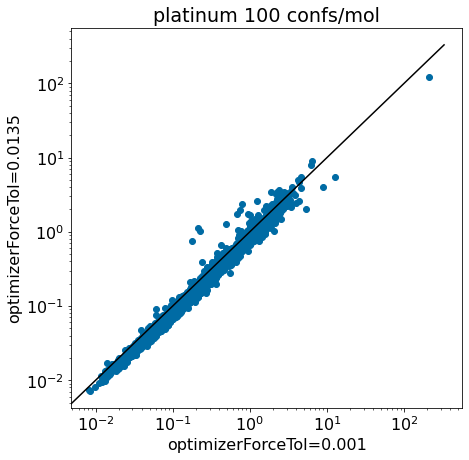

In [24]:
plt.rcParams['figure.figsize'] = (7,7)

plt.scatter(base_runtimes,mod_runtimes)
lim = max(base_runtimes+mod_runtimes)
plt.plot((0,lim),(0,lim),'k')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('optimizerForceTol=0.001')
plt.ylabel('optimizerForceTol=0.0135')
plt.title('platinum 100 confs/mol');

It's clear that most of those points are below the diagonal, indicating that using the new value of `optimizerForceTol` results in shorter run times.

Do a histogram of the differences in run time:

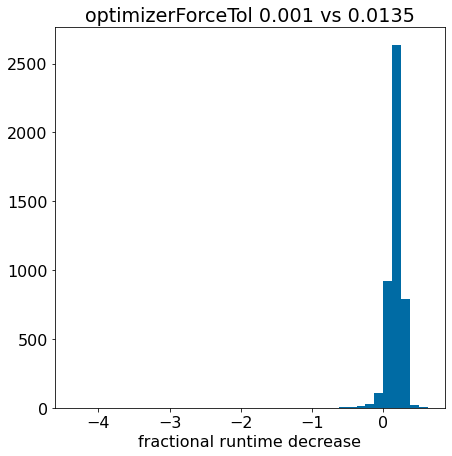

In [25]:
pcts = (base_runtimes - mod_runtimes) / base_runtimes
plt.hist(pcts,bins=40);
plt.xlabel('fractional runtime decrease');
plt.title('optimizerForceTol 0.001 vs 0.0135');

There's an extreme outlier there, remove it so that we can actually see something:

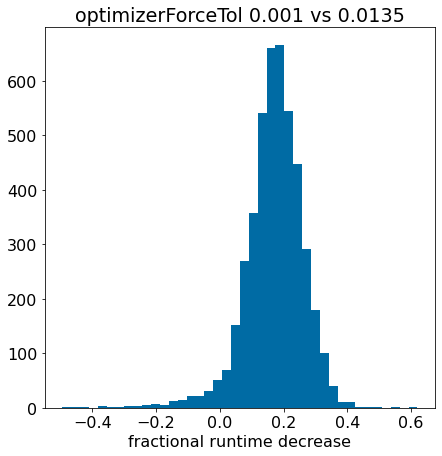

In [26]:
plt.hist([x for x in pcts if x>-0.5],bins=40);
plt.xlabel('fractional runtime decrease');
plt.title('optimizerForceTol 0.001 vs 0.0135');

The fact that the histgram is clearly shifted to the right indicates that using `optimizerForceTol=0.0135` spends things up for most of the molecules.

Now lets look at the fraction of the compounds appearing in various $\Delta$ time bins:

In [27]:
bins = [-10,-.1,-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,10]
nPts = len(pcts)
for i in range(len(bins)-1):
    frac = len([x for x in pcts if x>bins[i] and x<=bins[i+1]])/nPts
    print(f'{bins[i]: .2f} - {bins[i+1]: .2f}: {frac: .3f}')

-10.00 - -0.10:  0.017
-0.10 - -0.05:  0.009
-0.05 -  0.00:  0.014
 0.00 -  0.05:  0.036
 0.05 -  0.10:  0.095
 0.10 -  0.15:  0.194
 0.15 -  0.20:  0.263
 0.20 -  0.25:  0.206
 0.25 -  0.30:  0.112
 0.30 -  10.00:  0.054


And a set of quantiles for the $\Delta$ time values:

In [29]:
for q in [0.2,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(f'{q} {np.quantile(pcts,q):.3f}')

0.2 0.109
0.4 0.157
0.5 0.175
0.6 0.195
0.7 0.215
0.8 0.241
0.9 0.274


Ok, so we see an overall improvement of about 20%. How much do the conformers change?

We start by doing a direct comparison of the conformers to each other.

In [30]:
import gzip
import pickle
from rdkit.Chem import AllChem

rms_by_mol = []
with gzip.open('./results/platinum_forcetol_0.001.100confs.pkl.gz') as basef,\
     gzip.open('./results/platinum_forcetol_0.0135.100confs.pkl.gz') as modf:
    while 1:
        try:
            m1 = Chem.RemoveHs(pickle.load(basef))
            m2 = Chem.RemoveHs(pickle.load(modf))
        except EOFError:
            break
        m_res = []
        for conf1,conf2 in zip(m1.GetConformers(),m2.GetConformers()):
            rms = AllChem.GetBestRMS(m1,m2,conf1.GetId(),conf2.GetId())
            m_res.append(rms)
        rms_by_mol.append(m_res)

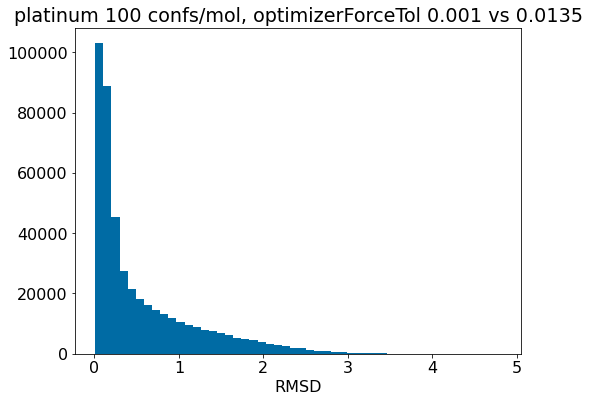

In [31]:
all_rms = []
for t in rms_by_mol:
    all_rms.extend(t)

plt.rcParams['figure.figsize'] = (8,6)    
plt.hist(all_rms,bins=50);
plt.xlabel('RMSD')
plt.title('platinum 100 confs/mol, optimizerForceTol 0.001 vs 0.0135');

So there are clear differences between the conformers generated using the two different force tolerances.

Do they matter? Let's look at our ability to reproduce crystal conformers to see.


## Comparison to crystal conformers

Is there an impact on our ability to find the crystal conformer?

### RMSD

In [32]:
inf = gzip.open('../data/platinum_dataset_2017_01.sdf.gz')

base_xtal_rms = []
mod_xtal_rms = []
with gzip.open('./results/platinum_forcetol_0.001.100confs.pkl.gz') as basef,\
     gzip.open('./results/platinum_forcetol_0.0135.100confs.pkl.gz') as modf:
    for i,m in enumerate(Chem.ForwardSDMolSupplier(inf,removeHs=False)):
        if not m:
            continue
        if m.GetNumHeavyAtoms()>50:
            continue
        m = Chem.RemoveHs(m)
        try:
            m1 = Chem.RemoveHs(pickle.load(basef))
            m2 = Chem.RemoveHs(pickle.load(modf))
        except EOFError:
            break
        base_best = 1000
        mod_best = 1000
        for conf1,conf2 in zip(m1.GetConformers(),m2.GetConformers()):
            rms = AllChem.GetBestRMS(m1,m,conf1.GetId())
            base_best = min(base_best,rms)
            rms = AllChem.GetBestRMS(m2,m,conf2.GetId())
            mod_best = min(mod_best,rms)
        if base_best<1000 and mod_best<1000:
            base_xtal_rms.append(base_best)
            mod_xtal_rms.append(mod_best)


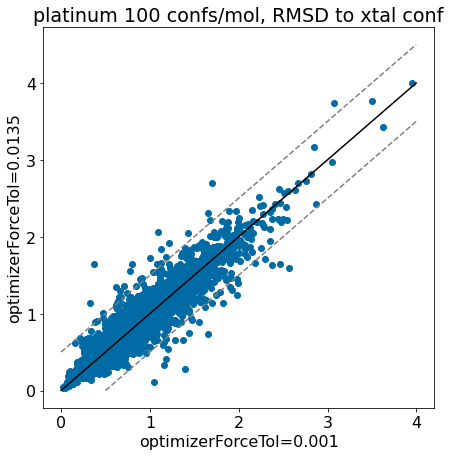

In [33]:
thresh = 0.5
plt.rcParams['figure.figsize']=(7,7)
plt.scatter(base_xtal_rms,mod_xtal_rms);
lim = max(base_xtal_rms+mod_xtal_rms)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, RMSD to xtal conf');

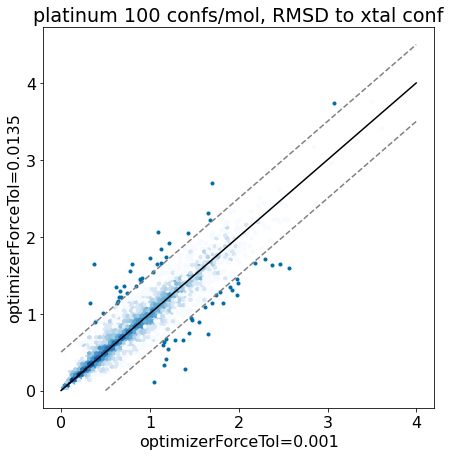

In [34]:
thresh = 0.5
plt.rcParams['figure.figsize']=(7,7)
plt.hexbin(base_xtal_rms,mod_xtal_rms,cmap='Blues',bins='log');
outside = [(x,y) for x,y in zip(base_xtal_rms,mod_xtal_rms) if abs(x-y)>thresh]
plt.scatter([x for x,y in outside],[y for x,y in outside],marker='.')
lim = max(base_xtal_rms+mod_xtal_rms)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, RMSD to xtal conf');

Based on these plots it looks like we haven't negatively impacted our ability to reproduce crystal conformers.

Let's look at the $\Delta$ RMSD differences directly:

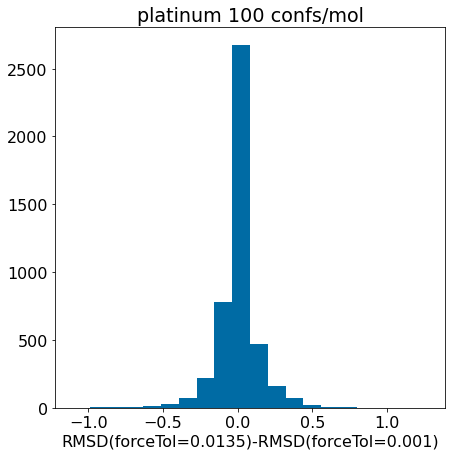

In [37]:
d = np.array(mod_xtal_rms)-np.array(base_xtal_rms)
plt.hist(d,bins=20);
plt.xlabel('RMSD(forceTol=0.0135)-RMSD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

Zoom in:

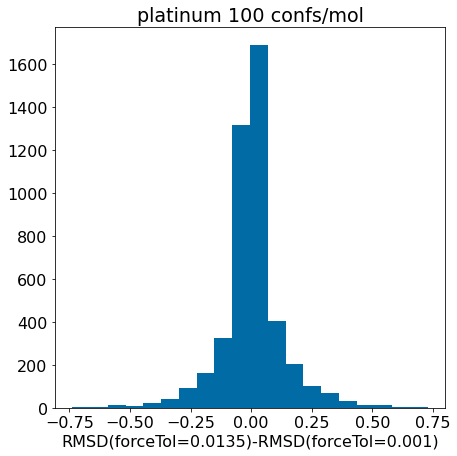

In [38]:
d = np.array(mod_xtal_rms)-np.array(base_xtal_rms)
plt.hist([x for x in d if abs(x)<=0.75],bins=20);
plt.xlabel('RMSD(forceTol=0.0135)-RMSD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

There really aren't significant changes here.

### TFD

RMSD, though familiar and intuitive, has some well-documented shortcomings. [Torsion Fingerprint Differences (TFDs)](https://doi.org/10.1021/ci2002318) were developed as an alternative metric for comparing structures which is less susceptible to some of these problems. 

We used TFDs in the original ETKDG paper, so let's try them here too

In [17]:
# The RDKit's TFD implementation doesn't currently (v2022.03) have a fast implementation of
# the method we need, so do it directly here:
def GetBestTFDBetweenMolecules(mol1, mol2, confId1=-1, useWeights=True, maxDev='equal',
                           symmRadius=2, ignoreColinearBonds=True):
  """ Wrapper to calculate the TFD between two molecules.
      All conformers of mol2 will be compared against a single conformer of mol1
      and the lowest TFD returned
      
      Important: The two molecules must be instances of the same molecule

      Arguments:
      - mol1:     first instance of the molecule of interest
      - mol2:     second instance the molecule of interest
      - confId1:  conformer index for mol1 (default: first conformer)
      - useWeights: flag for using torsion weights in the TFD calculation
      - maxDev:   maximal deviation used for normalization
                  'equal': all torsions are normalized using 180.0 (default)
                  'spec':  each torsion is normalized using its specific
                           maximal deviation as given in the paper
      - symmRadius: radius used for calculating the atom invariants
                    (default: 2)
      - ignoreColinearBonds: if True (default), single bonds adjacent to
                             triple bonds are ignored
                             if False, alternative not-covalently bound
                             atoms are used to define the torsion

      Return: TFD value
  """
  if (Chem.MolToSmiles(mol1) != Chem.MolToSmiles(mol2)):
    raise ValueError("The two molecules must be instances of the same molecule!")
  mol2 = TorsionFingerprints._getSameAtomOrder(mol1, mol2)
  tl, tlr = TorsionFingerprints.CalculateTorsionLists(mol1, maxDev=maxDev, symmRadius=symmRadius,
                                  ignoreColinearBonds=ignoreColinearBonds)
  # first molecule
  torsion1 = TorsionFingerprints.CalculateTorsionAngles(mol1, tl, tlr, confId=confId1)
  if useWeights:
    weights = TorsionFingerprints.CalculateTorsionWeights(mol1, ignoreColinearBonds=ignoreColinearBonds)
  best = 1e8
  for conf in mol2.GetConformers():
    # second molecule
    torsion2 = TorsionFingerprints.CalculateTorsionAngles(mol2, tl, tlr, confId=conf.GetId())
    if useWeights:
      tfd = TorsionFingerprints.CalculateTFD(torsion1, torsion2, weights=weights)
    else:
      tfd = TorsionFingerprints.CalculateTFD(torsion1, torsion2)
    best = min(best,tfd)
  return best

In [41]:
inf = gzip.open('../data/platinum_dataset_2017_01.sdf.gz')
base_xtal_tfd = []
mod_xtal_tfd = []
with gzip.open('./results/platinum_forcetol_0.001.100confs.pkl.gz') as basef,\
     gzip.open('./results/platinum_forcetol_0.0135.100confs.pkl.gz') as modf:
    for i,m in enumerate(Chem.ForwardSDMolSupplier(inf,removeHs=False)):
        if not m:
            continue
        if m.GetNumHeavyAtoms()>50:
            continue
        m = Chem.RemoveHs(m)
        try:
            m1 = Chem.RemoveHs(pickle.load(basef))
            m2 = Chem.RemoveHs(pickle.load(modf))
        except EOFError:
            break
        base_best = 1000
        mod_best = 1000
        base_best = GetBestTFDBetweenMolecules(m,m1)
        mod_best = GetBestTFDBetweenMolecules(m,m2)
        if base_best<1000 and mod_best<1000:
            base_xtal_tfd.append(base_best)
            mod_xtal_tfd.append(mod_best)
        if not (i+1)%500:
            print(f"Done {i+1}")

Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500


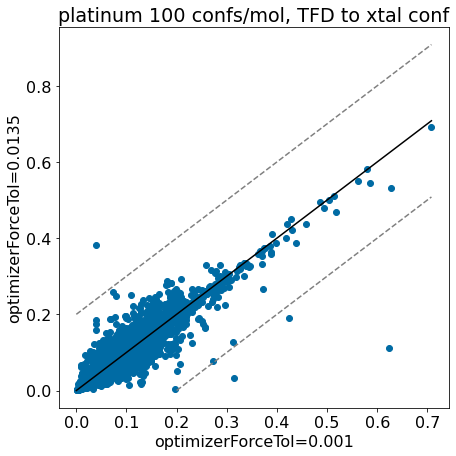

In [42]:
thresh = 0.2
plt.rcParams['figure.figsize']=(7,7)
plt.scatter(base_xtal_tfd,mod_xtal_tfd);
lim = max(base_xtal_tfd+mod_xtal_tfd)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, TFD to xtal conf');

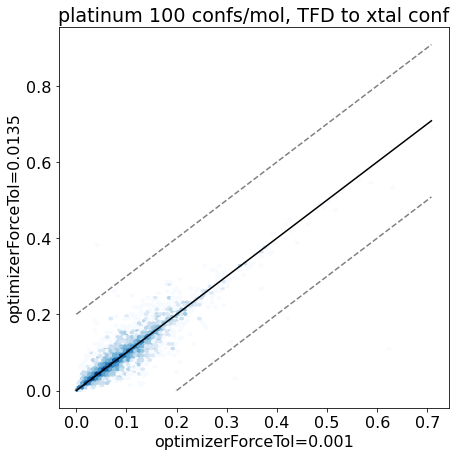

In [43]:
thresh = 0.2
plt.rcParams['figure.figsize']=(7,7)
plt.hexbin(base_xtal_tfd,mod_xtal_tfd,cmap='Blues',bins='log');
lim = max(base_xtal_tfd+mod_xtal_tfd)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, TFD to xtal conf');

Look at the histogram of the changes in TFD between the two methods

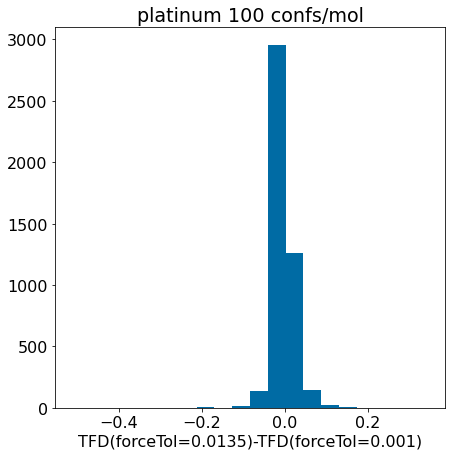

In [44]:
d = np.array(mod_xtal_tfd)-np.array(base_xtal_tfd)
plt.hist(d,bins=20);
plt.xlabel('TFD(forceTol=0.0135)-TFD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

Zoom in:

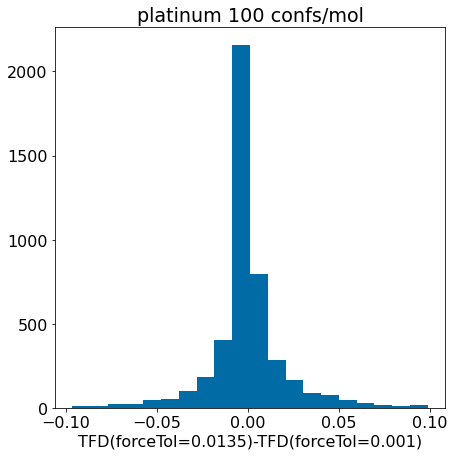

In [46]:
d = np.array(mod_xtal_tfd)-np.array(base_xtal_tfd)
plt.hist([x for x in d if abs(x)<0.1],bins=20);
plt.xlabel('TFD(forceTol=0.0135)-TFD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

Conclusion: the updated force field parameters don't have a much of an impact at all on our ability to reproduce crystal conformers as measured by TFD.

# Repeat the analysis for random-coordinate embedding

The [random-coordinate embedding scheme](https://doi.org/10.1016/s1093-3263(97)00014-4) is more robust than standard embedding, but it is (as implemented in the RDKit) also slower. Let's see how much it is affected by the modified `optimizerForceTol`

In [4]:
import pickle
with open('./results/optmizer_force_tol_timings.random_coords.pkl','rb') as inf:
   timings = pickle.load(inf)
base_runtimes,mod_runtimes = timings
base_runtimes = np.array(base_runtimes)
mod_runtimes = np.array(mod_runtimes)

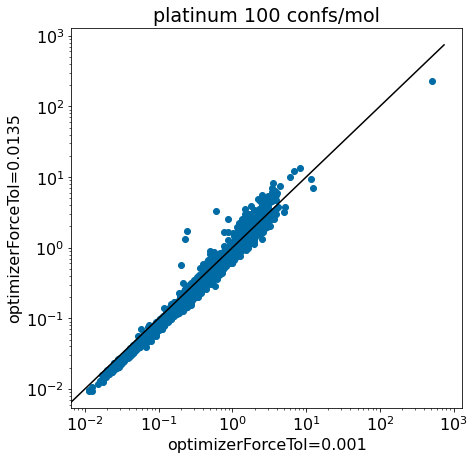

In [5]:
plt.rcParams['figure.figsize'] = (7,7)

plt.scatter(base_runtimes,mod_runtimes)
lim = max(base_runtimes+mod_runtimes)
plt.plot((0,lim),(0,lim),'k')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('optimizerForceTol=0.001')
plt.ylabel('optimizerForceTol=0.0135')
plt.title('platinum 100 confs/mol');

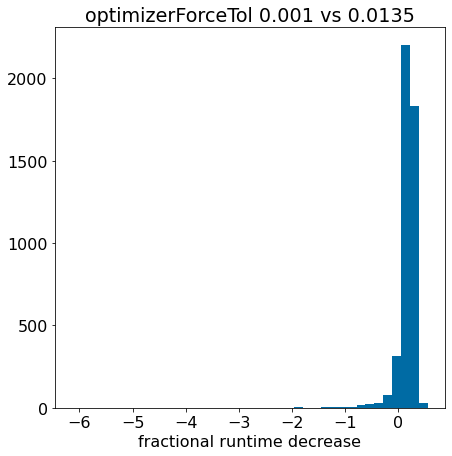

In [6]:
pcts = (base_runtimes - mod_runtimes) / base_runtimes
plt.hist(pcts,bins=40);
plt.xlabel('fractional runtime decrease');
plt.title('optimizerForceTol 0.001 vs 0.0135');

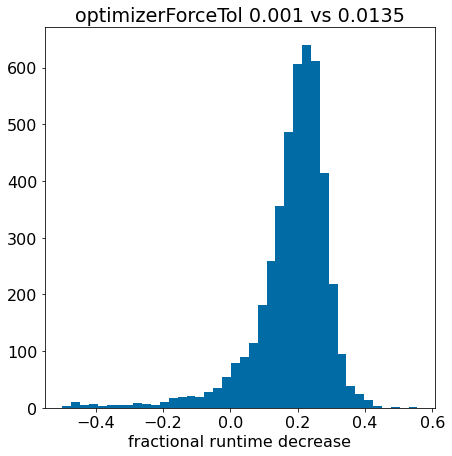

In [7]:
plt.hist([x for x in pcts if x>-0.5],bins=40);
plt.xlabel('fractional runtime decrease');
plt.title('optimizerForceTol 0.001 vs 0.0135');

There are a small number of compounds here where things get worse, but it looks like there is an overall improvement similar to what we saw before.

Look at the bins and quantiles to quantify that:

In [8]:
bins = [-10,-.1,-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,10]
nPts = len(pcts)
for i in range(len(bins)-1):
    frac = len([x for x in pcts if x>bins[i] and x<=bins[i+1]])/nPts
    print(f'{bins[i]: .2f} - {bins[i+1]: .2f}: {frac: .3f}')

-10.00 - -0.10:  0.040
-0.10 - -0.05:  0.010
-0.05 -  0.00:  0.019
 0.00 -  0.05:  0.034
 0.05 -  0.10:  0.057
 0.10 -  0.15:  0.115
 0.15 -  0.20:  0.210
 0.20 -  0.25:  0.261
 0.25 -  0.30:  0.185
 0.30 -  10.00:  0.069


In [9]:
for q in [0.2,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(f'{q} {np.quantile(pcts,q):.3f}')

0.2 0.121
0.4 0.183
0.5 0.204
0.6 0.223
0.7 0.241
0.8 0.261
0.9 0.288


So the impact here is actually a bit larger than for standard embedding.

## Comparing to crystal structures

### RMSD

In [13]:
import gzip
inf = gzip.open('../data/platinum_dataset_2017_01.sdf.gz')

base_xtal_rms = []
mod_xtal_rms = []
with gzip.open('./results/platinum_forcetol_0.001.random_coords.100confs.pkl.gz') as basef,\
     gzip.open('./results/platinum_forcetol_0.0135.random_coords.100confs.pkl.gz') as modf:
    for i,m in enumerate(Chem.ForwardSDMolSupplier(inf,removeHs=False)):
        if not m:
            continue
        if m.GetNumHeavyAtoms()>50:
            continue
        m = Chem.RemoveHs(m)
        try:
            m1 = Chem.RemoveHs(pickle.load(basef))
            m2 = Chem.RemoveHs(pickle.load(modf))
        except EOFError:
            break
        base_best = 1000
        mod_best = 1000
        for conf1,conf2 in zip(m1.GetConformers(),m2.GetConformers()):
            rms = AllChem.GetBestRMS(m1,m,conf1.GetId())
            base_best = min(base_best,rms)
            rms = AllChem.GetBestRMS(m2,m,conf2.GetId())
            mod_best = min(mod_best,rms)
        if base_best<1000 and mod_best<1000:
            base_xtal_rms.append(base_best)
            mod_xtal_rms.append(mod_best)


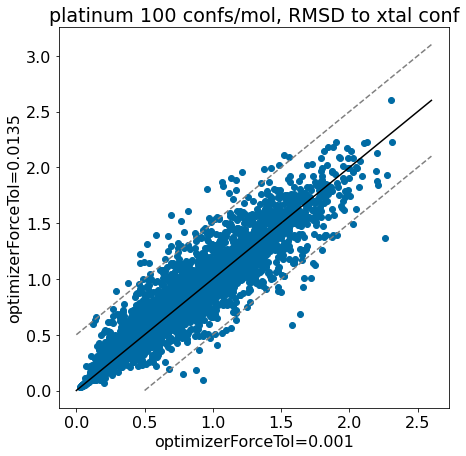

In [14]:
thresh = 0.5
plt.rcParams['figure.figsize']=(7,7)
plt.scatter(base_xtal_rms,mod_xtal_rms);
lim = max(base_xtal_rms+mod_xtal_rms)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, RMSD to xtal conf');

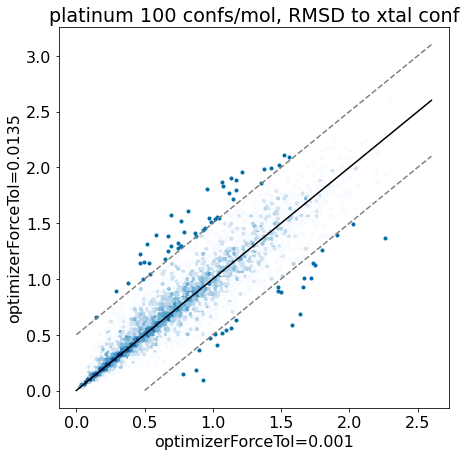

In [15]:
thresh = 0.5
plt.rcParams['figure.figsize']=(7,7)
plt.hexbin(base_xtal_rms,mod_xtal_rms,cmap='Blues',bins='log');
outside = [(x,y) for x,y in zip(base_xtal_rms,mod_xtal_rms) if abs(x-y)>thresh]
plt.scatter([x for x,y in outside],[y for x,y in outside],marker='.')
lim = max(base_xtal_rms+mod_xtal_rms)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, RMSD to xtal conf');

Once again, it looks like we haven't negatively impacted our ability to reproduce crystal conformers in any serious way.

Let's look at the $\Delta$ RMSD differences directly:

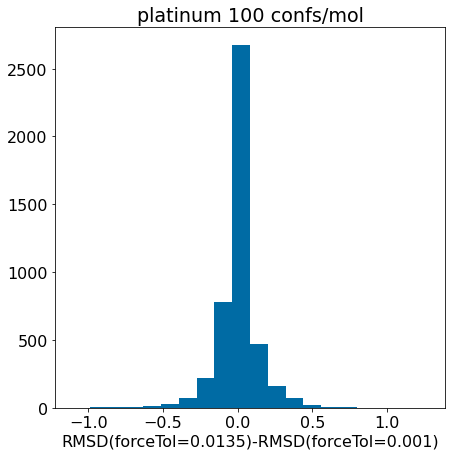

In [37]:
d = np.array(mod_xtal_rms)-np.array(base_xtal_rms)
plt.hist(d,bins=20);
plt.xlabel('RMSD(forceTol=0.0135)-RMSD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

Zoom in:

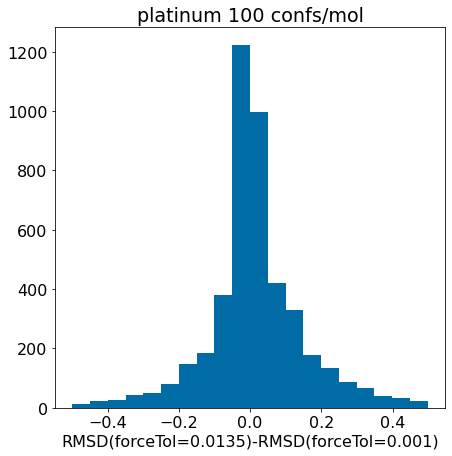

In [16]:
d = np.array(mod_xtal_rms)-np.array(base_xtal_rms)
plt.hist([x for x in d if abs(x)<=0.5],bins=20);
plt.xlabel('RMSD(forceTol=0.0135)-RMSD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

### TFDs

In [24]:
inf = gzip.open('../data/platinum_dataset_2017_01.sdf.gz')
base_xtal_tfd = []
mod_xtal_tfd = []
with gzip.open('./results/platinum_forcetol_0.001.random_coords.100confs.pkl.gz') as basef,\
     gzip.open('./results/platinum_forcetol_0.0135.random_coords.100confs.pkl.gz') as modf:
    for i,m in enumerate(Chem.ForwardSDMolSupplier(inf,removeHs=False)):
        if not m:
            continue
        if m.GetNumHeavyAtoms()>50:
            continue
        m = Chem.RemoveHs(m)
        try:
            m1 = Chem.RemoveHs(pickle.load(basef))
            m2 = Chem.RemoveHs(pickle.load(modf))
        except EOFError:
            break
        base_best = 1000
        mod_best = 1000
        base_best = GetBestTFDBetweenMolecules(m,m1)
        mod_best = GetBestTFDBetweenMolecules(m,m2)
        if base_best<1000 and mod_best<1000:
            base_xtal_tfd.append(base_best)
            mod_xtal_tfd.append(mod_best)
        if not (i+1)%500:
            print(f"Done {i+1}")

Done 500
Done 1000
Done 1500
Done 2000
Done 2500
Done 3000
Done 3500
Done 4000
Done 4500


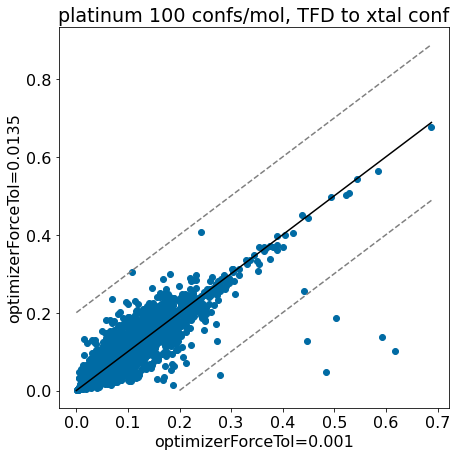

In [25]:
thresh = 0.2
plt.rcParams['figure.figsize']=(7,7)
plt.scatter(base_xtal_tfd,mod_xtal_tfd);
lim = max(base_xtal_tfd+mod_xtal_tfd)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, TFD to xtal conf');

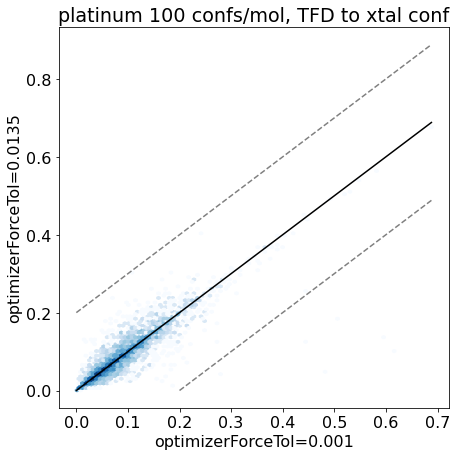

In [26]:
thresh = 0.2
plt.rcParams['figure.figsize']=(7,7)
plt.hexbin(base_xtal_tfd,mod_xtal_tfd,cmap='Blues',bins='log');
lim = max(base_xtal_tfd+mod_xtal_tfd)
plt.plot((0,lim),(0,lim),'k')
plt.plot((0,lim),(thresh,lim+thresh),ls='dashed',color='grey')
plt.plot((thresh,lim),(0,lim-thresh),ls='dashed',color='grey');
plt.xlabel('optimizerForceTol=0.001');
plt.ylabel('optimizerForceTol=0.0135');
plt.title('platinum 100 confs/mol, TFD to xtal conf');

Look at the histogram of the changes in TFD between the two methods

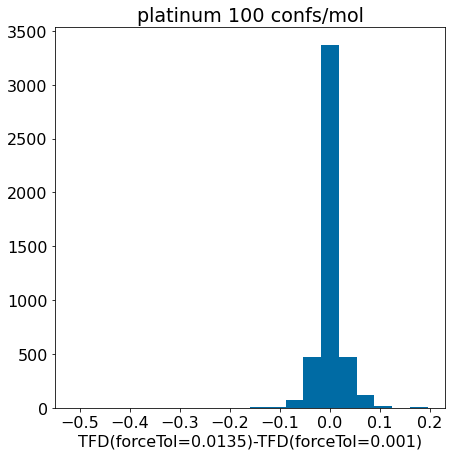

In [27]:
d = np.array(mod_xtal_tfd)-np.array(base_xtal_tfd)
plt.hist(d,bins=20);
plt.xlabel('TFD(forceTol=0.0135)-TFD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

Zoom in:

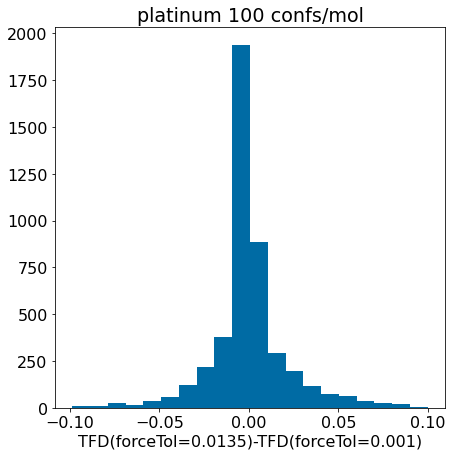

In [28]:
d = np.array(mod_xtal_tfd)-np.array(base_xtal_tfd)
plt.hist([x for x in d if abs(x)<0.1],bins=20);
plt.xlabel('TFD(forceTol=0.0135)-TFD(forceTol=0.001)')
plt.title('platinum 100 confs/mol');

Again, there are no major changes seen here.